In [21]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [22]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
 
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)
 
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [23]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

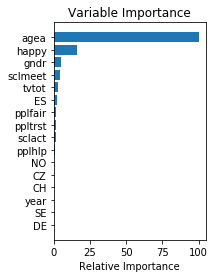

In [24]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [25]:
# Automatic feature selection

import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X_train.columns[i] for i in indicies_selected]
X_selected = X_train[colnames_selected]
print(colnames_selected)
x_train = X_train[colnames_selected]
x_test = X_test[colnames_selected]

['year', 'tvtot', 'ppltrst', 'pplfair', 'happy', 'sclmeet', 'gndr', 'agea', 'CH', 'CZ']


(array([4508.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2824.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

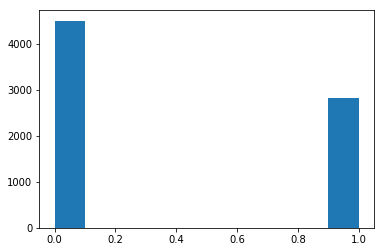

In [26]:
plt.hist(y_train)

In [27]:
params = {'n_estimators':1500 ,
          'max_depth': 3,
          'loss': 'exponential', 'random_state': 20, 'max_features': 'sqrt', 
          'learning_rate' : .01 ,'subsample' : .9 }
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']


print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

Training set accuracy:
Percent Type I errors: 0.04091653027823241
Percent Type II errors: 0.1815330060010911

Test set accuracy:
Percent Type I errors: 0.05889570552147239
Percent Type II errors: 0.18895705521472392
0.7775504637206765
0.7521472392638037


In [ ]:
# GridSearchCV for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = dict(max_depth= range(2,10), loss=['exponential','deviance'], 
                  n_estimators=range(500,1800,100),subsample= np.arange(.1,.9,.1))
grid = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid.fit(X_train, y_train)
 

In [82]:
print(grid.best_params_)
print(grid.best_score_)

{'loss': 'exponential', 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.1}
0.7516366612111293


In [28]:
 
params = {'n_estimators':600 ,
          'max_depth': 3,
          'loss': 'exponential', 'random_state': 20, 'max_features': 'sqrt', 
          'learning_rate' : .01 ,'subsample' : .1 }
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']


print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
print()
print(train_tI_errors/test_tI_errors)
print(train_tII_errors/test_tII_errors)


Training set accuracy:
Percent Type I errors: 0.036552100381887616
Percent Type II errors: 0.20076377523186034

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.20368098159509201
0.762684124386252
0.7386503067484662

0.6338289747072001
0.985677571168471


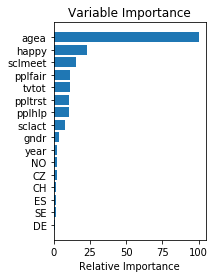

Index(['DE', 'SE', 'ES', 'CH', 'CZ', 'NO', 'year', 'gndr', 'sclact', 'pplhlp',
       'ppltrst', 'tvtot', 'pplfair', 'sclmeet', 'happy', 'agea'],
      dtype='object')


In [29]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
print(X_test.columns[sorted_idx] )

I played with the hyperparameters manually above the GridsearchCV and got a lower errors. I couldn't see to lower them any further.

In [4]:
((100*6)+(77.14*20)+(54*20)+(84*30)+(99*20)+(60*4))

7962.8

In [6]:
80-78.6

1.4000000000000057